# Synchronise multiple QDAC-IIs

In [1]:
from time import sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
from qcodes_contrib_drivers.drivers.QDevil import QDAC2
from qcodes_contrib_drivers.drivers.QDevil import QDAC2_Array
qdac1_addr = '192.168.8.17'
qdac1 = QDAC2.QDac2('QDAC_1', visalib='@py', address=f'TCPIP::{qdac1_addr}::5025::SOCKET')
qdac2_addr = '192.168.8.19'
qdac2 = QDAC2.QDac2('QDAC_2', visalib='@py', address=f'TCPIP::{qdac2_addr}::5025::SOCKET')
from qcodes.instrument_drivers.rigol import RigolDS1074Z
rigol_addr = '192.168.8.199'
scope = RigolDS1074Z('rigol', visalib='@py', address=f'TCPIP::{rigol_addr}::INSTR')

Connected to: QDevil QDAC-II (serial:3, firmware:11-1.14) in 0.21s
Connected to: QDevil QDAC-II (serial:2, firmware:11-1.14) in 0.27s
Connected to: RIGOL TECHNOLOGIES DS1104Z (serial:DS1ZA171812151, firmware:00.04.03) in 0.09s


In [2]:
scope.write('*rst')
qdac1.reset()
qdac2.reset()
sleep(5)

In [3]:
def capture():
    scope.write('stop')
    scope.write(":disp:data?")
    bmpdata = scope.visa_handle.read_raw()[2+9:]
    image = Image(data=bmpdata)
    display(image)

In [4]:
# Connect the two QDAC-IIs together as described in section 5.5 of the manual
qdacs = QDAC2_Array.QDac2_Array(qdac1, [qdac2])
controller, listener, *_ = qdacs.names
print(f'Controller: {controller}')
print(f'Listener: {listener}')

Controller: QDAC_1
Listener: QDAC_2


In [5]:
# Make the listerner use the controller as clock
qdacs.sync()

In [6]:
# Assign a name to channel 6 on qdac1 and channel 5 on qdac2
contacts = {controller: {'G1': 6}, listener: {'G2': 5}}
arrangement = qdacs.arrange(contacts)

In [7]:
# Prepare a square wave on each instrument, to be started by the 
# interconnected external trigger (see section 5.5 in manual).
for contact in ('G1', 'G2'):
    square = arrangement.channel(contact).square_wave(period_s=10e-6, span_V=1)
    square.start_on_external(qdacs.common_trigger_in)

In [8]:
# Use an internal trigger to start the instruments at the same time.
start_trigger = qdacs.allocate_trigger()
qdacs.connect_external_trigger(qdacs.trigger_out, start_trigger)

In [9]:
# Connect scope ch 1 & 2 to qdacs' ch 6 & 5
scope.write('chan1:disp on')
scope.write('chan1:bwl on')
scope.write('chan1:prob 1')
scope.write('chan1:scal 0.25')
scope.write('chan1:offs 0.1')
scope.write('chan2:disp on')
scope.write('chan2:bwl on')
scope.write('chan2:prob 1')
scope.write('chan2:scal 0.25')
scope.write('chan2:offs -0.1')
scope.write('trig:edge:sour chan1')
scope.write('trig:edge:level 0.25')
scope.write('tim:scal 2e-6')
scope.write('tim:offs 8e-6')

In [10]:
scope.write('sing')
sleep(3)
# Start the wave forms.
qdacs.trigger(start_trigger)

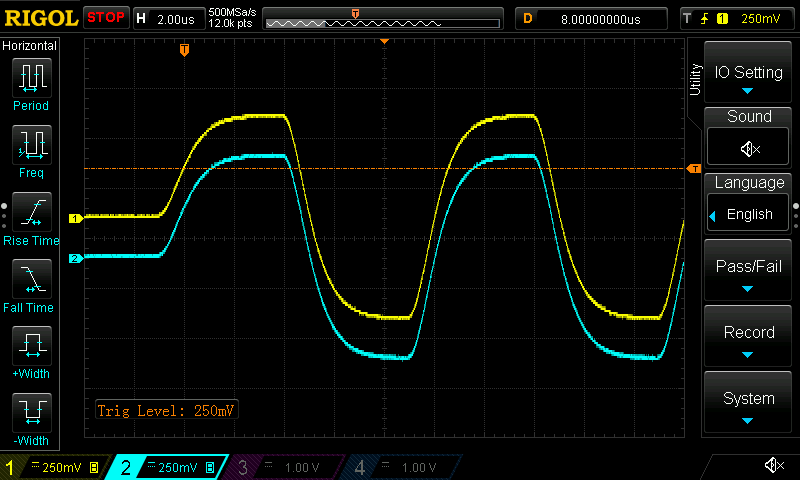

In [11]:
capture()

In [12]:
# Stop waveforms
for contact in ('G1', 'G2'):
    arrangement.channel(contact).abort()